In [18]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
data_dir = "/Users/esbishop/Sea_snakes_images/Images"   # Path to image directory

In [3]:
# We need to define some parameters for the laoder: 
batch_size = 32
img_height = 180
img_width = 180

In [4]:
# It's good practice to use a validation split when developing a model. Let's use 80% of the images for training, 
# and 20% for validation. 
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1340 files belonging to 2 classes.
Using 1072 files for training.
Metal device set to: Apple M1


2022-01-21 08:10:56.614560: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-21 08:10:56.614774: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1340 files belonging to 2 classes.
Using 268 files for validation.


In [6]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory = "/Users/esbishop/Sea_snakes_images/test_images",
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 314 files belonging to 2 classes.


In [7]:
# We can have a look at the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order. 
class_names = train_ds.class_names
print(class_names)

['rope', 'snake']


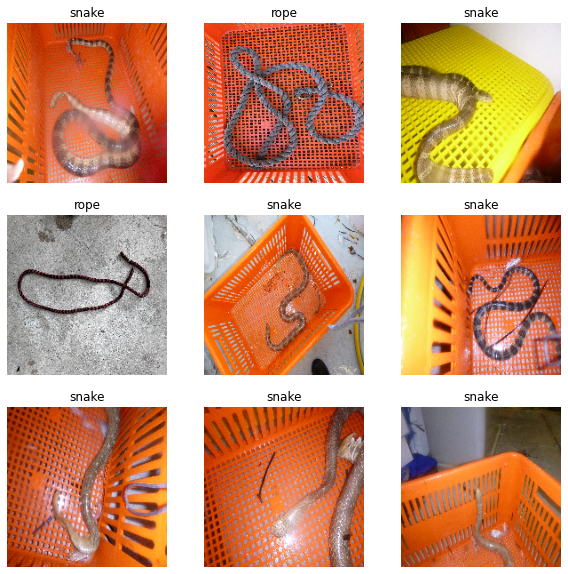

In [25]:
# We can have a look at the first 9 images from the training dataset: 

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
with tf.device('/CPU:0'):
    data_augmentation = keras.Sequential(
      [
        layers.RandomFlip("horizontal",
                          input_shape=(img_height,
                                      img_width,
                                      3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
      ]
    )

In [10]:
num_classes = len(class_names)

inputs = keras.Input(shape = (180,180,3))
x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x) #The first layer is a normal conv2D layer, as RGB colour channels are highly correlated. We will start using SeparableConv2D afterwards. 

for size in [32, 64, 128, 256, 512]:
    residual = x
    
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)
    
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)
    
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    
    residual = layers.Conv2D(
        size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])
    
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1, activation = "sigmoid")(x)
outputs = layers.Dense(num_classes)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
    
    

In [11]:
model.compile(optimizer='adam',      # 'adam' is an adaptive optimiser which is good with sparse datasets 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # computes crossentropy loss between labels and predictions. Use when there are two or more label classes are integers rather than binary or one-hot encoded. 
              metrics=['accuracy'])

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 180, 180, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 180, 180, 3)  0           sequential[0][0]                 
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 176, 176, 32) 2400        rescaling[0][0]                  
______________________________________________________________________________________________

In [13]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = "convnet_from_scratch_updated.keras",
        save_best_only = True, 
        monitor = "val_loss")
]

In [15]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callbacks
)

Epoch 1/50
34/34 [==============================] - ETA: 0s - loss: 0.5239 - accuracy: 0.8358

2022-01-21 08:12:38.778471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-21 08:12:48.868007: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 241 of 256
2022-01-21 08:12:49.572225: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


34/34 [==============================] - 31s 910ms/step - loss: 0.5239 - accuracy: 0.8358 - val_loss: 0.7986 - val_accuracy: 0.5224
Epoch 2/50


/Users/esbishop/miniforge3/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


34/34 [==============================] - 18s 511ms/step - loss: 0.4705 - accuracy: 0.9506 - val_loss: 0.8040 - val_accuracy: 0.5224
Epoch 3/50
34/34 [==============================] - 17s 510ms/step - loss: 0.4496 - accuracy: 0.9627 - val_loss: 0.7528 - val_accuracy: 0.5410
Epoch 4/50
34/34 [==============================] - 17s 509ms/step - loss: 0.4458 - accuracy: 0.9562 - val_loss: 0.8021 - val_accuracy: 0.5299
Epoch 5/50
34/34 [==============================] - 18s 518ms/step - loss: 0.4398 - accuracy: 0.9468 - val_loss: 0.8272 - val_accuracy: 0.5261
Epoch 6/50
34/34 [==============================] - 17s 511ms/step - loss: 0.4184 - accuracy: 0.9664 - val_loss: 0.8557 - val_accuracy: 0.5224
Epoch 7/50
34/34 [==============================] - 17s 510ms/step - loss: 0.4056 - accuracy: 0.9711 - val_loss: 0.8618 - val_accuracy: 0.5224
Epoch 8/50
34/34 [==============================] - 18s 516ms/step - loss: 0.4072 - accuracy: 0.9534 - val_loss: 0.7134 - val_accuracy: 0.6082
Epoch 9/50

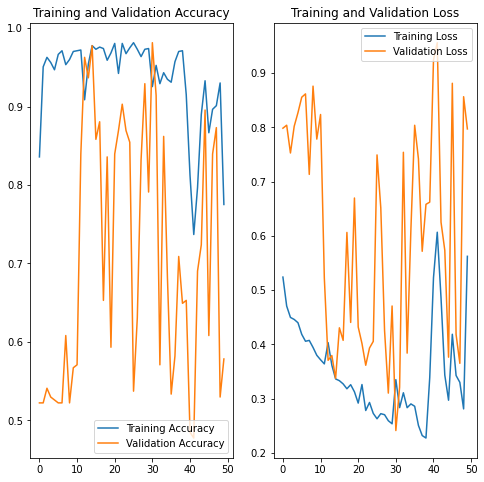

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
test_model = keras.models.load_model("convnet_from_scratch_updated.keras") 
test_loss, test_acc = test_model.evaluate(test_ds) 
print(f"Test accuracy: {test_acc:.3f}")

2022-01-21 08:28:05.110995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 11s 177ms/step - loss: 0.2414 - accuracy: 0.9873
Test accuracy: 0.987
